In [1]:
import pandas as pd
import numpy as np
import time
import random
import sqlite3
import copy
from plotnine import *
import matplotlib.pyplot as plt
import plotly.figure_factory as ff

In [2]:
url = "https://github.com/nytimes/covid-19-data/blob/master/prisons/facilities.csv"

#use pandas to read in tables from webpage
prison_data = pd.read_html(url)

In [3]:
#convert list to df
prison_df = pd.concat(prison_data, ignore_index = True)

In [4]:
prison_df.head()

,Unnamed: 0,nyt_id,facility_name,facility_type,facility_city,facility_county,facility_county_fips,facility_state,facility_lng,facility_lat,latest_inmate_population,max_inmate_population_2020,total_inmate_cases,total_inmate_deaths,total_officer_cases,total_officer_deaths,note
0,NaN,F3EFE858,Alex City Work Release prison,Low-security work release,Alex City,Coosa,1037,Alabama,-86.009015,32.904507,188.0,NaN,77,0,17,0.0,NaN
1,NaN,5B910220,Alabama Therapeutic Education Facility prison,State rehabilitation center,Columbiana,Shelby,1117,Alabama,-86.624067,33.180755,272.0,NaN,11,1,2,0.0,NaN
2,NaN,02FB1675,Bibb Correctional Facility,State prison,Brent,Bibb,1007,Alabama,-87.162781,32.920754,1725.0,1825.0,164,3,61,0.0,NaN
3,NaN,6378F6C4,Birmingham Women's Community Based Facility an...,State prison,Birmingham,Jefferson,1073,Alabama,-86.808344,33.531101,192.0,NaN,17,0,28,0.0,NaN
4,NaN,EAABF900,Bullock Correctional Facility,State prison,Bessemer,Bullock,1011,Alabama,-85.673927,32.147144,1477.0,1577.0,162,5,80,1.0,NaN


In [5]:
prison_df = prison_df.dropna(subset=['facility_county_fips', 'latest_inmate_population'])
#prison_df = prison_df.loc[prison_df.facility_type == "State prison"].reset_index()
prison_df = prison_df.loc[(prison_df.facility_type == "State prison") | (prison_df.facility_type == "Federal prison")].reset_index()

In [6]:
prison_df['max_inmate_population_2020'] = prison_df.max_inmate_population_2020.fillna(prison_df.latest_inmate_population)

In [7]:
prison_df_county = prison_df.groupby(['facility_county_fips', 'facility_county', 'facility_state'])[['max_inmate_population_2020', 'total_inmate_cases', 'total_inmate_deaths']].sum().reset_index()

In [8]:
prison_df_county

,facility_county_fips,facility_county,facility_state,max_inmate_population_2020,total_inmate_cases,total_inmate_deaths
0,1003,Baldwin,Alabama,128.0,106,0
1,1005,Barbour,Alabama,2411.0,149,4
2,1007,Bibb,Alabama,1825.0,164,3
3,1011,Bullock,Alabama,1577.0,162,5
4,1051,Elmore,Alabama,3871.0,296,8
...,...,...,...,...,...,...
755,56013,Fremont,Wyoming,205.0,203,0
756,56015,Goshen,Wyoming,583.0,71,0
757,56027,Niobrara,Wyoming,281.0,3,0
758,56045,Weston,Wyoming,213.0,182,0


In [9]:
county_covid_data = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')

In [10]:
county_covid_df = county_covid_data.loc[county_covid_data.date == "2021-03-31"]

In [11]:
county_covid_df['fips'] = np.where((county_covid_df.county == 'New York City'),36061,county_covid_df.fips)

In [12]:
county_covid_df

,date,county,state,fips,cases,deaths
1173623,2021-03-31,Autauga,Alabama,1001.0,6589,99.0
1173624,2021-03-31,Baldwin,Alabama,1003.0,20505,301.0
1173625,2021-03-31,Barbour,Alabama,1005.0,2227,55.0
1173626,2021-03-31,Bibb,Alabama,1007.0,2542,58.0
1173627,2021-03-31,Blount,Alabama,1009.0,6444,131.0
...,...,...,...,...,...,...
1176865,2021-03-31,Sweetwater,Wyoming,56037.0,4022,37.0
1176866,2021-03-31,Teton,Wyoming,56039.0,3609,9.0
1176867,2021-03-31,Uinta,Wyoming,56041.0,2128,12.0
1176868,2021-03-31,Washakie,Wyoming,56043.0,890,26.0


In [13]:
final_county = prison_df_county.merge(county_covid_df, left_on='facility_county_fips', right_on='fips', how='left')

In [14]:
final_county

,facility_county_fips,facility_county,facility_state,max_inmate_population_2020,total_inmate_cases,total_inmate_deaths,date,county,state,fips,cases,deaths
0,1003,Baldwin,Alabama,128.0,106,0,2021-03-31,Baldwin,Alabama,1003.0,20505.0,301.0
1,1005,Barbour,Alabama,2411.0,149,4,2021-03-31,Barbour,Alabama,1005.0,2227.0,55.0
2,1007,Bibb,Alabama,1825.0,164,3,2021-03-31,Bibb,Alabama,1007.0,2542.0,58.0
3,1011,Bullock,Alabama,1577.0,162,5,2021-03-31,Bullock,Alabama,1011.0,1207.0,40.0
4,1051,Elmore,Alabama,3871.0,296,8,2021-03-31,Elmore,Alabama,1051.0,9953.0,202.0
...,...,...,...,...,...,...,...,...,...,...,...,...
755,56013,Fremont,Wyoming,205.0,203,0,2021-03-31,Fremont,Wyoming,56013.0,5070.0,82.0
756,56015,Goshen,Wyoming,583.0,71,0,2021-03-31,Goshen,Wyoming,56015.0,1169.0,23.0
757,56027,Niobrara,Wyoming,281.0,3,0,2021-03-31,Niobrara,Wyoming,56027.0,150.0,2.0
758,56045,Weston,Wyoming,213.0,182,0,2021-03-31,Weston,Wyoming,56045.0,633.0,5.0


In [15]:
final_county = final_county.loc[final_county.facility_state != "Puerto Rico"].reset_index()


In [16]:
#Read in demographic data

population="/Users/anandigupta/Downloads/PopulationEstimates.csv"
populationdat = (pd.read_csv(population))

unemployment="/Users/anandigupta/Downloads/Unemployment.csv"
unemploymentdat = (pd.read_csv(unemployment))

poverty="/Users/anandigupta/Downloads/PovertyEstimates.csv"
povertydat=(pd.read_csv(poverty))

education="/Users/anandigupta/Downloads/Education.csv"
eddat=(pd.read_csv(education))

insurance="/Users/anandigupta/Downloads/SAHIE_13DEC21_14_29_28_65.csv"
insdat=(pd.read_csv(insurance))

race = "/Users/anandigupta/Downloads/cc-est2019-alldata.csv"
racedat=(pd.read_csv(race))

county_vote = pd.read_csv("/Users/anandigupta/Downloads/countypres_2000-2020.tab",sep='\t',header=(0))

incarceration = "/Users/anandigupta/Downloads/census_incarceration_TMP.csv"
incarcdat=(pd.read_csv(incarceration))

popdens = "/Users/anandigupta/Downloads/Average_Household_Size_and_Population_Density_-_County.csv"
popdensdat = (pd.read_csv(popdens))

In [17]:
populationdat
populationdat = populationdat[['FIPStxt', 'Population 2020']]
populationdat['Population 2020'] = populationdat['Population 2020'].str.replace(',', '')

In [18]:
populationdat= populationdat.dropna(subset = ['Population 2020'])
populationdat['Population 2020'] = populationdat['Population 2020'].astype('int64')

In [19]:
populationdat.head()

,FIPStxt,Population 2020
0,0,331449281
1,1000,5024279
2,1001,58805
3,1003,231767
4,1005,25223


In [20]:
unemploymentdat.head()
unemploymentdat = unemploymentdat[['FIPS_Code', 'Unemployment_rate_2019', 'Unemployment_rate_2020', 'Median_Household_Income_2019']]
unemploymentdat['Median_Household_Income_2019'] = unemploymentdat['Median_Household_Income_2019'].str.replace(',', '')
unemploymentdat['Median_Household_Income_2019'] = unemploymentdat['Median_Household_Income_2019'].astype('float64')


In [21]:
unemploymentdat.head()

,FIPS_Code,Unemployment_rate_2019,Unemployment_rate_2020,Median_Household_Income_2019
0,0,3.7,8.1,65712.0
1,1000,3.0,5.9,51771.0
2,1001,2.7,4.9,58233.0
3,1003,2.8,5.6,59871.0
4,1005,3.8,7.0,35972.0


In [22]:
povertydat = povertydat[['FIPStxt', 'PCTPOVALL_2019']]
povertydat.head()

,FIPStxt,PCTPOVALL_2019
0,0,12.3
1,1000,15.6
2,1001,12.1
3,1003,10.1
4,1005,27.1


In [23]:
type(populationdat.FIPStxt[0])

numpy.int64

In [24]:
eddat = eddat[['FIPS Code', 'Percent of adults with less than a high school diploma, 2015-19', 'Percent of adults with a high school diploma only, 2015-19', "Percent of adults with a bachelor's degree or higher, 2015-19"]]
eddat.head()

,FIPS Code,"Percent of adults with less than a high school diploma, 2015-19","Percent of adults with a high school diploma only, 2015-19","Percent of adults with a bachelor's degree or higher, 2015-19"
0,0,12.0,27.0,32.1
1,1000,13.8,30.8,25.5
2,1001,11.5,33.6,26.6
3,1003,9.2,27.7,31.9
4,1005,26.8,35.6,11.6


In [25]:
type(eddat['FIPS Code'][0])

numpy.int64

In [26]:
insdat = insdat[['ID','Uninsured: %']]
insdat.head()

,ID,Uninsured: %
0,1000,11.6
1,1001,9.4
2,1003,10.9
3,1005,13.0
4,1007,11.0


In [27]:
type(insdat['ID'][0])

numpy.int64

In [28]:
racedat = racedat.loc[racedat.AGEGRP == 0].reset_index()
racedat = racedat.loc[racedat.YEAR == 12].reset_index()
racedat.head()

,level_0,index,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,YEAR,AGEGRP,TOT_POP,...,HWAC_MALE,HWAC_FEMALE,HBAC_MALE,HBAC_FEMALE,HIAC_MALE,HIAC_FEMALE,HAAC_MALE,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE
0,11,209,50,1,1,Alabama,Autauga County,12,0,55869,...,778,687,89,93,40,27,15,19,16,11
1,23,437,50,1,3,Alabama,Baldwin County,12,0,223234,...,5144,4646,268,281,264,197,69,65,55,35
2,35,665,50,1,5,Alabama,Barbour County,12,0,24686,...,509,408,63,50,61,26,1,0,14,8
3,47,893,50,1,7,Alabama,Bibb County,12,0,22394,...,291,253,32,19,6,15,5,1,17,3
4,59,1121,50,1,9,Alabama,Blount County,12,0,57826,...,2794,2516,76,58,67,66,18,21,34,21


In [29]:
racedat['COUNTY'] = racedat['COUNTY'].astype(str).str.zfill(3)
racedat['STATE'] = racedat['STATE'].astype(str).str.zfill(2)
racedat["FIPS"] =racedat["STATE"] + racedat["COUNTY"]


In [30]:
racedat["FIPS"] =racedat["FIPS"].astype('int64')

In [31]:
racedat.head()

,level_0,index,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,YEAR,AGEGRP,TOT_POP,...,HWAC_FEMALE,HBAC_MALE,HBAC_FEMALE,HIAC_MALE,HIAC_FEMALE,HAAC_MALE,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE,FIPS
0,11,209,50,01,001,Alabama,Autauga County,12,0,55869,...,687,89,93,40,27,15,19,16,11,1001
1,23,437,50,01,003,Alabama,Baldwin County,12,0,223234,...,4646,268,281,264,197,69,65,55,35,1003
2,35,665,50,01,005,Alabama,Barbour County,12,0,24686,...,408,63,50,61,26,1,0,14,8,1005
3,47,893,50,01,007,Alabama,Bibb County,12,0,22394,...,253,32,19,6,15,5,1,17,3,1007
4,59,1121,50,01,009,Alabama,Blount County,12,0,57826,...,2516,76,58,67,66,18,21,34,21,1009


In [32]:
racedat['pct_white'] = (racedat['WA_MALE'] +  racedat['WA_FEMALE'])/ racedat['TOT_POP']
racedat = racedat[['FIPS', 'pct_white']]

In [33]:
county_vote.head()
county_vote = county_vote.loc[county_vote['candidate'] == "DONALD TRUMP"].reset_index()
county_vote = county_vote.loc[county_vote['year'] == 2016].reset_index()
county_vote.head()

,level_0,index,year,state,state_po,county_name,county_fips,office,candidate,party,candidatevotes,totalvotes,version,mode
0,0,40518,2016,ALABAMA,AL,AUTAUGA,1001.0,PRESIDENT,DONALD TRUMP,REPUBLICAN,18172.0,24973.0,20191203,TOTAL
1,1,40521,2016,ALABAMA,AL,BALDWIN,1003.0,PRESIDENT,DONALD TRUMP,REPUBLICAN,72883.0,95215.0,20191203,TOTAL
2,2,40524,2016,ALABAMA,AL,BARBOUR,1005.0,PRESIDENT,DONALD TRUMP,REPUBLICAN,5454.0,10469.0,20191203,TOTAL
3,3,40527,2016,ALABAMA,AL,BIBB,1007.0,PRESIDENT,DONALD TRUMP,REPUBLICAN,6738.0,8819.0,20191203,TOTAL
4,4,40530,2016,ALABAMA,AL,BLOUNT,1009.0,PRESIDENT,DONALD TRUMP,REPUBLICAN,22859.0,25588.0,20191203,TOTAL


In [34]:
final_county['fips'].unique

<bound method Series.unique of 0       1003.0
1       1005.0
2       1007.0
3       1011.0
4       1051.0
        ...   
754    56007.0
755    56013.0
756    56015.0
757    56027.0
758    56045.0
Name: fips, Length: 759, dtype: float64>

In [35]:
county_vote['trump_vote_share'] = county_vote['candidatevotes'] / county_vote['totalvotes']

In [36]:
county_vote = county_vote[['county_fips', 'trump_vote_share']]
county_vote

,county_fips,trump_vote_share
0,1001.0,0.727666
1,1003.0,0.765457
2,1005.0,0.520967
3,1007.0,0.764032
4,1009.0,0.893348
...,...,...
3153,2037.0,0.382853
3154,2038.0,0.224338
3155,2039.0,0.249158
3156,2040.0,0.298698


In [37]:
incarcdat.head()

incarcdat['incarc_rate'] = incarcdat['incarcerated_20']/incarcdat['total_population_20']
incarcdat = incarcdat[['FIPS', 'incarc_rate']]


In [38]:
incarcdat.head()

,FIPS,incarc_rate
0,25001,0.000930
1,25003,0.001457
2,25005,0.001528
3,25007,0.000728
4,25009,0.002615


In [39]:
url = "https://www.prisonpolicy.org/blog/2020/12/21/overcrowding/"

prison_capacity = "/Users/anandigupta/Downloads/Capacity.csv"
prison_capacity_dat=(pd.read_csv(prison_capacity))

In [40]:
prison_capacity_dat

,Prison system,Capacity_max,Capacity_min,As of this date:,Unnamed: 4,Unnamed: 5
0,Alabama,1.53,0.86,Sept. 2020,NaN,NaN
1,Alaska,0.85,0.82,"May 1, 2020",NaN,NaN
2,Arizona,0.98,0.85,"Dec. 2, 2020",NaN,NaN
3,Arkansas,1.03,0.99,Sept. 2020,NaN,NaN
4,California,1.10,0.78,"Dec. 2, 2020",NaN,NaN
5,Colorado,1.17,1.05,End of Nov. 2020,NaN,NaN
6,Delaware,1.25,0.91,"May 1, 2020",NaN,NaN
7,Federal,1.03,1.03,"Dec. 3, 2020",NaN,NaN
8,Florida,1.06,1.06,"May 1, 2020",NaN,NaN
9,Georgia,0.87,0.75,"Dec. 4, 2020",NaN,NaN


In [41]:
rural_urban = "/Users/anandigupta/Downloads/ruralurbancodes2013.csv"
rural_urban_codes=(pd.read_csv(rural_urban))
rural_urban_codes = rural_urban_codes.dropna(subset = ['FIPS'])
rural_urban_codes

,FIPS,State,County_Name,Population_2010,RUCC_2013,Description
0,1001.0,AL,Autauga County,"54,571",2.0,"Metro - Counties in metro areas of 250,000 to ..."
1,1003.0,AL,Baldwin County,"182,265",3.0,Metro - Counties in metro areas of fewer than ...
2,1005.0,AL,Barbour County,"27,457",6.0,"Nonmetro - Urban population of 2,500 to 19,999..."
3,1007.0,AL,Bibb County,"22,915",1.0,Metro - Counties in metro areas of 1 million p...
4,1009.0,AL,Blount County,"57,322",1.0,Metro - Counties in metro areas of 1 million p...
...,...,...,...,...,...,...
3229,72151.0,PR,Yabucoa Municipio,"37,941",1.0,Metro - Counties in metro areas of 1 million p...
3230,72153.0,PR,Yauco Municipio,"42,043",2.0,"Metro - Counties in metro areas of 250,000 to ..."
3231,78010.0,VI,St. Croix Island,"50,601",5.0,"Nonmetro - Urban population of 20,000 or more,..."
3232,78020.0,VI,St. John Island,"4,170",7.0,"Nonmetro - Urban population of 2,500 to 19,999..."


In [42]:
populationdat['FIPStxt'].unique

<bound method Series.unique of 0           0
1        1000
2        1001
3        1003
4        1005
        ...  
3275    72145
3276    72147
3277    72149
3278    72151
3279    72153
Name: FIPStxt, Length: 3274, dtype: int64>

In [43]:
final_county = final_county.merge(populationdat, left_on= 'facility_county_fips', right_on= 'FIPStxt', how='left').merge(unemploymentdat, left_on= 'facility_county_fips', right_on= 'FIPS_Code', how='left').merge(racedat, left_on= 'facility_county_fips', right_on= 'FIPS', how='left').merge(eddat, left_on= 'facility_county_fips', right_on= 'FIPS Code', how='left').merge(insdat, left_on= 'facility_county_fips', right_on= 'ID', how='left').merge(povertydat, left_on= 'facility_county_fips', right_on= 'FIPStxt', how='left').merge(county_vote, left_on= 'facility_county_fips', right_on= 'county_fips', how='left').merge(incarcdat, left_on= 'facility_county_fips', right_on= 'FIPS', how='left')

In [44]:
final_county

,index,facility_county_fips,facility_county,facility_state,max_inmate_population_2020,total_inmate_cases,total_inmate_deaths,date,county,state,...,"Percent of adults with a high school diploma only, 2015-19","Percent of adults with a bachelor's degree or higher, 2015-19",ID,Uninsured: %,FIPStxt_y,PCTPOVALL_2019,county_fips,trump_vote_share,FIPS_y,incarc_rate
0,0,1003,Baldwin,Alabama,128.0,106,0,2021-03-31,Baldwin,Alabama,...,27.7,31.9,1003,10.9,1003,10.1,1003.0,0.765457,1003,0.005303
1,1,1005,Barbour,Alabama,2411.0,149,4,2021-03-31,Barbour,Alabama,...,35.6,11.6,1005,13.0,1005,27.1,1005.0,0.520967,1005,0.099790
2,2,1007,Bibb,Alabama,1825.0,164,3,2021-03-31,Bibb,Alabama,...,44.9,10.4,1007,11.0,1007,20.3,1007.0,0.764032,1007,0.083255
3,3,1011,Bullock,Alabama,1577.0,162,5,2021-03-31,Bullock,Alabama,...,40.3,12.1,1011,11.1,1011,30.0,1011.0,0.242038,1011,0.152554
4,4,1051,Elmore,Alabama,3871.0,296,8,2021-03-31,Elmore,Alabama,...,32.5,25.1,1051,8.9,1051,11.4,1051.0,0.741653,1051,0.060084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
754,754,56007,Carbon,Wyoming,826.0,420,1,2021-03-31,Carbon,Wyoming,...,38.2,20.6,56007,17.7,56007,11.7,56007.0,0.691716,56007,0.037009
755,755,56013,Fremont,Wyoming,205.0,203,0,2021-03-31,Fremont,Wyoming,...,29.7,24.3,56013,22.3,56013,12.9,56013.0,0.655995,56013,0.008640
756,756,56015,Goshen,Wyoming,583.0,71,0,2021-03-31,Goshen,Wyoming,...,28.2,25.9,56015,15.5,56015,13.0,56015.0,0.762250,56015,0.048088
757,757,56027,Niobrara,Wyoming,281.0,3,0,2021-03-31,Niobrara,Wyoming,...,34.7,18.0,56027,19.1,56027,15.1,56027.0,0.849315,56027,0.112282


In [45]:
final_county = final_county.dropna(subset = ['Population 2020', 'cases'])
#final_county['Population 2020'] =final_county['Population 2020'].astype('int64')
#final_county['cases'] = final_county['cases'].astype('int64')

In [46]:
final_county['inmate_cases_per_100'] = final_county['total_inmate_cases']/final_county['max_inmate_population_2020']*100
final_county['inmate_deaths_per_1000'] = final_county['total_inmate_deaths']/final_county['max_inmate_population_2020']*1000
final_county['cases_per_100'] = final_county['cases']/final_county['Population 2020']*100
final_county['deaths_per_1000'] = final_county['deaths']/final_county['Population 2020']*1000
final_county['cases_diff'] = final_county['inmate_cases_per_100']-final_county['cases_per_100']
final_county['deaths_diff'] = final_county['inmate_deaths_per_1000']-final_county['deaths_per_1000']

In [47]:
final_county

,index,facility_county_fips,facility_county,facility_state,max_inmate_population_2020,total_inmate_cases,total_inmate_deaths,date,county,state,...,county_fips,trump_vote_share,FIPS_y,incarc_rate,inmate_cases_per_100,inmate_deaths_per_1000,cases_per_100,deaths_per_1000,cases_diff,deaths_diff
0,0,1003,Baldwin,Alabama,128.0,106,0,2021-03-31,Baldwin,Alabama,...,1003.0,0.765457,1003,0.005303,82.812500,0.000000,8.847247,1.298718,73.965253,-1.298718
1,1,1005,Barbour,Alabama,2411.0,149,4,2021-03-31,Barbour,Alabama,...,1005.0,0.520967,1005,0.099790,6.180008,1.659063,8.829243,2.180549,-2.649235,-0.521487
2,2,1007,Bibb,Alabama,1825.0,164,3,2021-03-31,Bibb,Alabama,...,1007.0,0.764032,1007,0.083255,8.986301,1.643836,11.402682,2.601714,-2.416381,-0.957878
3,3,1011,Bullock,Alabama,1577.0,162,5,2021-03-31,Bullock,Alabama,...,1011.0,0.242038,1011,0.152554,10.272670,3.170577,11.653954,3.862122,-1.381284,-0.691545
4,4,1051,Elmore,Alabama,3871.0,296,8,2021-03-31,Elmore,Alabama,...,1051.0,0.741653,1051,0.060084,7.646603,2.066649,11.313184,2.296055,-3.666581,-0.229405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
754,754,56007,Carbon,Wyoming,826.0,420,1,2021-03-31,Carbon,Wyoming,...,56007.0,0.691716,56007,0.037009,50.847458,1.210654,10.428562,1.582170,40.418896,-0.371516
755,755,56013,Fremont,Wyoming,205.0,203,0,2021-03-31,Fremont,Wyoming,...,56013.0,0.655995,56013,0.008640,99.024390,0.000000,12.922465,2.090024,86.101925,-2.090024
756,756,56015,Goshen,Wyoming,583.0,71,0,2021-03-31,Goshen,Wyoming,...,56015.0,0.762250,56015,0.048088,12.178388,0.000000,9.353497,1.840294,2.824891,-1.840294
757,757,56027,Niobrara,Wyoming,281.0,3,0,2021-03-31,Niobrara,Wyoming,...,56027.0,0.849315,56027,0.112282,1.067616,0.000000,6.080259,0.810701,-5.012644,-0.810701


In [48]:
#drop six instances with data errors (cases recorded in jails greater than number of inmates)
final_county = final_county.loc[final_county['inmate_cases_per_100'] < 100].reset_index()

In [49]:
final_county

,level_0,index,facility_county_fips,facility_county,facility_state,max_inmate_population_2020,total_inmate_cases,total_inmate_deaths,date,county,...,county_fips,trump_vote_share,FIPS_y,incarc_rate,inmate_cases_per_100,inmate_deaths_per_1000,cases_per_100,deaths_per_1000,cases_diff,deaths_diff
0,0,0,1003,Baldwin,Alabama,128.0,106,0,2021-03-31,Baldwin,...,1003.0,0.765457,1003,0.005303,82.812500,0.000000,8.847247,1.298718,73.965253,-1.298718
1,1,1,1005,Barbour,Alabama,2411.0,149,4,2021-03-31,Barbour,...,1005.0,0.520967,1005,0.099790,6.180008,1.659063,8.829243,2.180549,-2.649235,-0.521487
2,2,2,1007,Bibb,Alabama,1825.0,164,3,2021-03-31,Bibb,...,1007.0,0.764032,1007,0.083255,8.986301,1.643836,11.402682,2.601714,-2.416381,-0.957878
3,3,3,1011,Bullock,Alabama,1577.0,162,5,2021-03-31,Bullock,...,1011.0,0.242038,1011,0.152554,10.272670,3.170577,11.653954,3.862122,-1.381284,-0.691545
4,4,4,1051,Elmore,Alabama,3871.0,296,8,2021-03-31,Elmore,...,1051.0,0.741653,1051,0.060084,7.646603,2.066649,11.313184,2.296055,-3.666581,-0.229405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,754,754,56007,Carbon,Wyoming,826.0,420,1,2021-03-31,Carbon,...,56007.0,0.691716,56007,0.037009,50.847458,1.210654,10.428562,1.582170,40.418896,-0.371516
747,755,755,56013,Fremont,Wyoming,205.0,203,0,2021-03-31,Fremont,...,56013.0,0.655995,56013,0.008640,99.024390,0.000000,12.922465,2.090024,86.101925,-2.090024
748,756,756,56015,Goshen,Wyoming,583.0,71,0,2021-03-31,Goshen,...,56015.0,0.762250,56015,0.048088,12.178388,0.000000,9.353497,1.840294,2.824891,-1.840294
749,757,757,56027,Niobrara,Wyoming,281.0,3,0,2021-03-31,Niobrara,...,56027.0,0.849315,56027,0.112282,1.067616,0.000000,6.080259,0.810701,-5.012644,-0.810701


In [50]:
final_county = final_county.merge(prison_capacity_dat, left_on= 'facility_state', right_on= 'Prison system', how='left')
final_county

,level_0,index,facility_county_fips,facility_county,facility_state,max_inmate_population_2020,total_inmate_cases,total_inmate_deaths,date,county,...,cases_per_100,deaths_per_1000,cases_diff,deaths_diff,Prison system,Capacity_max,Capacity_min,As of this date:,Unnamed: 4,Unnamed: 5
0,0,0,1003,Baldwin,Alabama,128.0,106,0,2021-03-31,Baldwin,...,8.847247,1.298718,73.965253,-1.298718,Alabama,1.53,0.86,Sept. 2020,NaN,NaN
1,1,1,1005,Barbour,Alabama,2411.0,149,4,2021-03-31,Barbour,...,8.829243,2.180549,-2.649235,-0.521487,Alabama,1.53,0.86,Sept. 2020,NaN,NaN
2,2,2,1007,Bibb,Alabama,1825.0,164,3,2021-03-31,Bibb,...,11.402682,2.601714,-2.416381,-0.957878,Alabama,1.53,0.86,Sept. 2020,NaN,NaN
3,3,3,1011,Bullock,Alabama,1577.0,162,5,2021-03-31,Bullock,...,11.653954,3.862122,-1.381284,-0.691545,Alabama,1.53,0.86,Sept. 2020,NaN,NaN
4,4,4,1051,Elmore,Alabama,3871.0,296,8,2021-03-31,Elmore,...,11.313184,2.296055,-3.666581,-0.229405,Alabama,1.53,0.86,Sept. 2020,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,754,754,56007,Carbon,Wyoming,826.0,420,1,2021-03-31,Carbon,...,10.428562,1.582170,40.418896,-0.371516,Wyoming,0.98,0.94,"Sept. 30, 2020",NaN,NaN
747,755,755,56013,Fremont,Wyoming,205.0,203,0,2021-03-31,Fremont,...,12.922465,2.090024,86.101925,-2.090024,Wyoming,0.98,0.94,"Sept. 30, 2020",NaN,NaN
748,756,756,56015,Goshen,Wyoming,583.0,71,0,2021-03-31,Goshen,...,9.353497,1.840294,2.824891,-1.840294,Wyoming,0.98,0.94,"Sept. 30, 2020",NaN,NaN
749,757,757,56027,Niobrara,Wyoming,281.0,3,0,2021-03-31,Niobrara,...,6.080259,0.810701,-5.012644,-0.810701,Wyoming,0.98,0.94,"Sept. 30, 2020",NaN,NaN


In [51]:
final_county = final_county.merge(rural_urban_codes, left_on= 'facility_county_fips', right_on= 'FIPS', how='left')
final_county

,level_0,index,facility_county_fips,facility_county,facility_state,max_inmate_population_2020,total_inmate_cases,total_inmate_deaths,date,county,...,Capacity_min,As of this date:,Unnamed: 4,Unnamed: 5,FIPS,State,County_Name,Population_2010,RUCC_2013,Description
0,0,0,1003,Baldwin,Alabama,128.0,106,0,2021-03-31,Baldwin,...,0.86,Sept. 2020,NaN,NaN,1003.0,AL,Baldwin County,"182,265",3.0,Metro - Counties in metro areas of fewer than ...
1,1,1,1005,Barbour,Alabama,2411.0,149,4,2021-03-31,Barbour,...,0.86,Sept. 2020,NaN,NaN,1005.0,AL,Barbour County,"27,457",6.0,"Nonmetro - Urban population of 2,500 to 19,999..."
2,2,2,1007,Bibb,Alabama,1825.0,164,3,2021-03-31,Bibb,...,0.86,Sept. 2020,NaN,NaN,1007.0,AL,Bibb County,"22,915",1.0,Metro - Counties in metro areas of 1 million p...
3,3,3,1011,Bullock,Alabama,1577.0,162,5,2021-03-31,Bullock,...,0.86,Sept. 2020,NaN,NaN,1011.0,AL,Bullock County,"10,914",6.0,"Nonmetro - Urban population of 2,500 to 19,999..."
4,4,4,1051,Elmore,Alabama,3871.0,296,8,2021-03-31,Elmore,...,0.86,Sept. 2020,NaN,NaN,1051.0,AL,Elmore County,"79,303",2.0,"Metro - Counties in metro areas of 250,000 to ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,754,754,56007,Carbon,Wyoming,826.0,420,1,2021-03-31,Carbon,...,0.94,"Sept. 30, 2020",NaN,NaN,56007.0,WY,Carbon County,"15,885",7.0,"Nonmetro - Urban population of 2,500 to 19,999..."
747,755,755,56013,Fremont,Wyoming,205.0,203,0,2021-03-31,Fremont,...,0.94,"Sept. 30, 2020",NaN,NaN,56013.0,WY,Fremont County,"40,123",7.0,"Nonmetro - Urban population of 2,500 to 19,999..."
748,756,756,56015,Goshen,Wyoming,583.0,71,0,2021-03-31,Goshen,...,0.94,"Sept. 30, 2020",NaN,NaN,56015.0,WY,Goshen County,"13,249",7.0,"Nonmetro - Urban population of 2,500 to 19,999..."
749,757,757,56027,Niobrara,Wyoming,281.0,3,0,2021-03-31,Niobrara,...,0.94,"Sept. 30, 2020",NaN,NaN,56027.0,WY,Niobrara County,"2,484",9.0,"Nonmetro - Completely rural or less than 2,500..."


In [52]:
popdensdat.head()
popdesndat = popdensdat[['GEOID','B01001_calc_PopDensity']]

In [53]:
final_county = final_county.merge(popdesndat, left_on= 'facility_county_fips', right_on= 'GEOID', how='left')
final_county

,level_0,index,facility_county_fips,facility_county,facility_state,max_inmate_population_2020,total_inmate_cases,total_inmate_deaths,date,county,...,Unnamed: 4,Unnamed: 5,FIPS,State,County_Name,Population_2010,RUCC_2013,Description,GEOID,B01001_calc_PopDensity
0,0,0,1003,Baldwin,Alabama,128.0,106,0,2021-03-31,Baldwin,...,NaN,NaN,1003.0,AL,Baldwin County,"182,265",3.0,Metro - Counties in metro areas of fewer than ...,1003,50.541504
1,1,1,1005,Barbour,Alabama,2411.0,149,4,2021-03-31,Barbour,...,NaN,NaN,1005.0,AL,Barbour County,"27,457",6.0,"Nonmetro - Urban population of 2,500 to 19,999...",1005,11.247981
2,2,2,1007,Bibb,Alabama,1825.0,164,3,2021-03-31,Bibb,...,NaN,NaN,1007.0,AL,Bibb County,"22,915",1.0,Metro - Counties in metro areas of 1 million p...,1007,13.973114
3,3,3,1011,Bullock,Alabama,1577.0,162,5,2021-03-31,Bullock,...,NaN,NaN,1011.0,AL,Bullock County,"10,914",6.0,"Nonmetro - Urban population of 2,500 to 19,999...",1011,6.417620
4,4,4,1051,Elmore,Alabama,3871.0,296,8,2021-03-31,Elmore,...,NaN,NaN,1051.0,AL,Elmore County,"79,303",2.0,"Metro - Counties in metro areas of 250,000 to ...",1051,50.701440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,754,754,56007,Carbon,Wyoming,826.0,420,1,2021-03-31,Carbon,...,NaN,NaN,56007.0,WY,Carbon County,"15,885",7.0,"Nonmetro - Urban population of 2,500 to 19,999...",56007,0.756629
747,755,755,56013,Fremont,Wyoming,205.0,203,0,2021-03-31,Fremont,...,NaN,NaN,56013.0,WY,Fremont County,"40,123",7.0,"Nonmetro - Urban population of 2,500 to 19,999...",56013,1.684900
748,756,756,56015,Goshen,Wyoming,583.0,71,0,2021-03-31,Goshen,...,NaN,NaN,56015.0,WY,Goshen County,"13,249",7.0,"Nonmetro - Urban population of 2,500 to 19,999...",56015,2.331241
749,757,757,56027,Niobrara,Wyoming,281.0,3,0,2021-03-31,Niobrara,...,NaN,NaN,56027.0,WY,Niobrara County,"2,484",9.0,"Nonmetro - Completely rural or less than 2,500...",56027,0.359927


In [54]:
import geopandas as gp

In [55]:
import mapclassify

In [56]:
countyshp=('/Users/anandigupta/Downloads/USA_Counties/USA_Counties.shp')
countyshp=gp.read_file(countyshp)

In [57]:
countyshp['FIPS'] = countyshp['FIPS'].astype('int64')

In [58]:
countymap = countyshp.merge(final_county, how='left', left_on="FIPS", right_on= "facility_county_fips")

In [59]:
countymap

,FID,OBJECTID,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS_x,POPULATION,POP_SQMI,POP2010,...,Unnamed: 4,Unnamed: 5,FIPS_y,State,County_Name,Population_2010,RUCC_2013,Description,GEOID,B01001_calc_PopDensity
0,1,1,Autauga,Alabama,01,001,1001,58224,96.4,54571,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2,Baldwin,Alabama,01,003,1003,227660,138.8,182265,...,NaN,NaN,1003.0,AL,Baldwin County,"182,265",3.0,Metro - Counties in metro areas of fewer than ...,1003.0,50.541504
2,3,3,Barbour,Alabama,01,005,1005,26326,29.1,27457,...,NaN,NaN,1005.0,AL,Barbour County,"27,457",6.0,"Nonmetro - Urban population of 2,500 to 19,999...",1005.0,11.247981
3,4,4,Bibb,Alabama,01,007,1007,23066,36.8,22915,...,NaN,NaN,1007.0,AL,Bibb County,"22,915",1.0,Metro - Counties in metro areas of 1 million p...,1007.0,13.973114
4,5,5,Blount,Alabama,01,009,1009,59970,92.2,57322,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3215,3216,3216,Vega Baja,Puerto Rico,72,145,72145,0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3216,3217,3217,Vieques,Puerto Rico,72,147,72147,0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3217,3218,3218,Villalba,Puerto Rico,72,149,72149,0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3218,3219,3219,Yabucoa,Puerto Rico,72,151,72151,0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:title={'center':'Difference in Cases per 100 Population in Jails and the General Population by County'}>

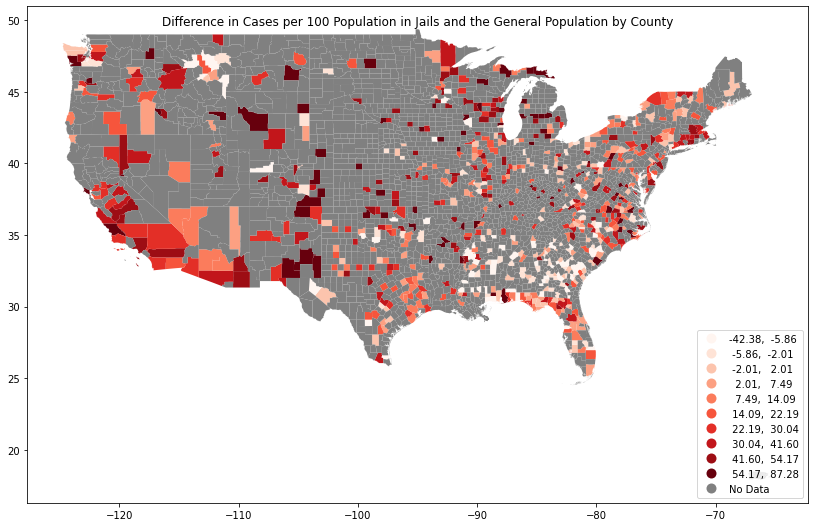

In [60]:
not_mainland = ['Alaska', 'Hawaii']
mainland_usa = countymap.query('STATE_NAME not in @not_mainland')
mainland_usa.sort_values("STATE_NAME")
missing_kwds = dict(color='grey', label='No Data')
fig, ax = plt.subplots(1, 1, figsize=[14,11])
plt.title("Difference in Cases per 100 Population in Jails and the General Population by County", x=.5, y=.95, fontname="DejaVu Sans"),
(mainland_usa.plot(column='cases_diff', cmap='Reds', scheme='quantiles', k=10, 
                  legend=True, ax=ax, legend_kwds={'loc': 'lower right'}, missing_kwds=missing_kwds))

<AxesSubplot:title={'center':'Difference in Deaths per 1000 Population in Jails and the General Population by County'}>

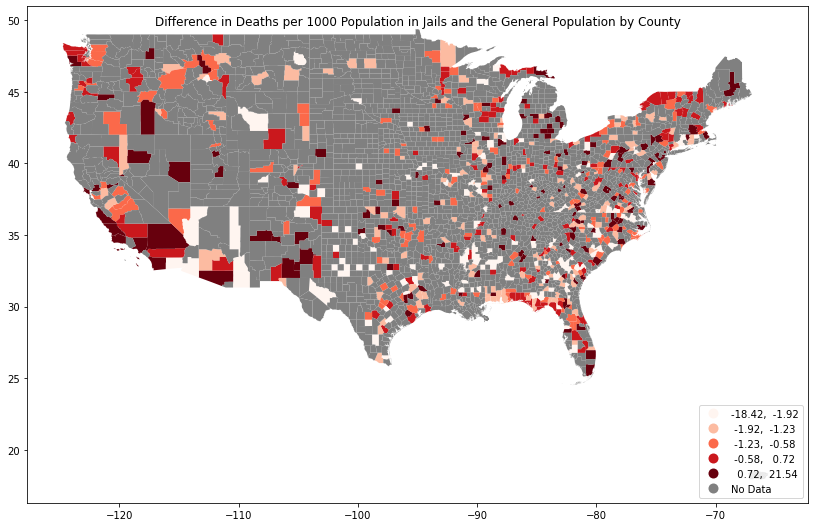

In [61]:
fig, ax = plt.subplots(1, 1, figsize=[14,11])
plt.title("Difference in Deaths per 1000 Population in Jails and the General Population by County", x=.5, y=.95, fontname="DejaVu Sans"),
(mainland_usa.plot(column='deaths_diff', cmap='Reds', scheme='quantiles', k=5, 
                  legend=True, ax=ax, legend_kwds={'loc': 'lower right'}, missing_kwds=missing_kwds))

# Data modeling

In [62]:
# Data Management/Investigation
import pandas as pd
from pandas.api.types import CategoricalDtype # Ordering categories
import numpy as np
import missingno as miss

# Plotting libraries
from plotnine import *
import matplotlib.pyplot as plt

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.tree import DecisionTreeRegressor as DT_reg
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn import tree # For plotting the decision tree rules

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# For model interpretation
from sklearn.inspection import (
    permutation_importance,
    partial_dependence, 
    PartialDependenceDisplay, 
    plot_partial_dependence
)

# Misc
import warnings
warnings.filterwarnings("ignore")

In [63]:
dat = final_county[['cases_diff', 'incarc_rate', 'pct_white', 'Unemployment_rate_2019', 'PCTPOVALL_2019', 'Median_Household_Income_2019', 'Uninsured: %', 'Percent of adults with less than a high school diploma, 2015-19', 'Percent of adults with a high school diploma only, 2015-19', "Percent of adults with a bachelor's degree or higher, 2015-19", 'trump_vote_share', 'B01001_calc_PopDensity', 'Capacity_min', 'Capacity_max', 'RUCC_2013']]
#dat = final_county[['cases_diff', 'incarc_rate', 'pct_white', 'Unemployment_rate_2019', 'PCTPOVALL_2019', 'Median_Household_Income_2019', 'Uninsured: %', 'Percent of adults with less than a high school diploma, 2015-19', 'Percent of adults with a high school diploma only, 2015-19', "Percent of adults with a bachelor's degree or higher, 2015-19", 'trump_vote_share', 'RUCC_2013']]
dat.head()


,cases_diff,incarc_rate,pct_white,Unemployment_rate_2019,PCTPOVALL_2019,Median_Household_Income_2019,Uninsured: %,"Percent of adults with less than a high school diploma, 2015-19","Percent of adults with a high school diploma only, 2015-19","Percent of adults with a bachelor's degree or higher, 2015-19",trump_vote_share,B01001_calc_PopDensity,Capacity_min,Capacity_max,RUCC_2013
0,73.965253,0.005303,0.874410,2.8,10.1,59871.0,10.9,9.2,27.7,31.9,0.765457,50.541504,0.86,1.53,3.0
1,-2.649235,0.099790,0.491534,3.8,27.1,35972.0,13.0,26.8,35.6,11.6,0.520967,11.247981,0.86,1.53,6.0
2,-2.416381,0.083255,0.767661,3.1,20.3,47918.0,11.0,20.9,44.9,10.4,0.764032,13.973114,0.86,1.53,1.0
3,-1.381284,0.152554,0.266211,3.7,30.0,31906.0,11.1,25.3,40.3,12.1,0.242038,6.417620,0.86,1.53,6.0
4,-3.666581,0.060084,0.756825,2.6,11.4,62310.0,8.9,13.4,32.5,25.1,0.741653,50.701440,0.86,1.53,2.0


In [64]:
dat.shape

(751, 15)

In [65]:
dat.dtypes

cases_diff                                                         float64
incarc_rate                                                        float64
pct_white                                                          float64
Unemployment_rate_2019                                             float64
PCTPOVALL_2019                                                     float64
Median_Household_Income_2019                                       float64
Uninsured: %                                                       float64
Percent of adults with less than a high school diploma, 2015-19    float64
Percent of adults with a high school diploma only, 2015-19         float64
Percent of adults with a bachelor's degree or higher, 2015-19      float64
trump_vote_share                                                   float64
B01001_calc_PopDensity                                             float64
Capacity_min                                                       float64
Capacity_max             

In [66]:
dat.isna().sum()

dat= dat.dropna()


In [67]:
dat

,cases_diff,incarc_rate,pct_white,Unemployment_rate_2019,PCTPOVALL_2019,Median_Household_Income_2019,Uninsured: %,"Percent of adults with less than a high school diploma, 2015-19","Percent of adults with a high school diploma only, 2015-19","Percent of adults with a bachelor's degree or higher, 2015-19",trump_vote_share,B01001_calc_PopDensity,Capacity_min,Capacity_max,RUCC_2013
0,73.965253,0.005303,0.874410,2.8,10.1,59871.0,10.9,9.2,27.7,31.9,0.765457,50.541504,0.86,1.53,3.0
1,-2.649235,0.099790,0.491534,3.8,27.1,35972.0,13.0,26.8,35.6,11.6,0.520967,11.247981,0.86,1.53,6.0
2,-2.416381,0.083255,0.767661,3.1,20.3,47918.0,11.0,20.9,44.9,10.4,0.764032,13.973114,0.86,1.53,1.0
3,-1.381284,0.152554,0.266211,3.7,30.0,31906.0,11.1,25.3,40.3,12.1,0.242038,6.417620,0.86,1.53,6.0
4,-3.666581,0.060084,0.756825,2.6,11.4,62310.0,8.9,13.4,32.5,25.1,0.741653,50.701440,0.86,1.53,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,40.418896,0.037009,0.939122,3.5,11.7,61626.0,17.7,9.0,38.2,20.6,0.691716,0.756629,0.94,0.98,7.0
747,86.101925,0.008640,0.737169,4.5,12.9,57953.0,22.3,7.9,29.7,24.3,0.655995,1.684900,0.94,0.98,7.0
748,2.824891,0.048088,0.947392,3.8,13.0,55540.0,15.5,7.9,28.2,25.9,0.762250,2.331241,0.94,0.98,7.0
749,-5.012644,0.112282,0.947368,2.8,15.1,48513.0,19.1,12.9,34.7,18.0,0.849315,0.359927,0.94,0.98,9.0


In [68]:
#Split data into train and test

y = dat[['cases_diff']]
X = dat.drop(columns=['cases_diff'])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=123)

In [69]:
print(train_X.shape[0]/dat.shape[0])
print(test_X.shape[0]/dat.shape[0])

0.7487266553480475
0.25127334465195245


## Explore the training data

<AxesSubplot:>

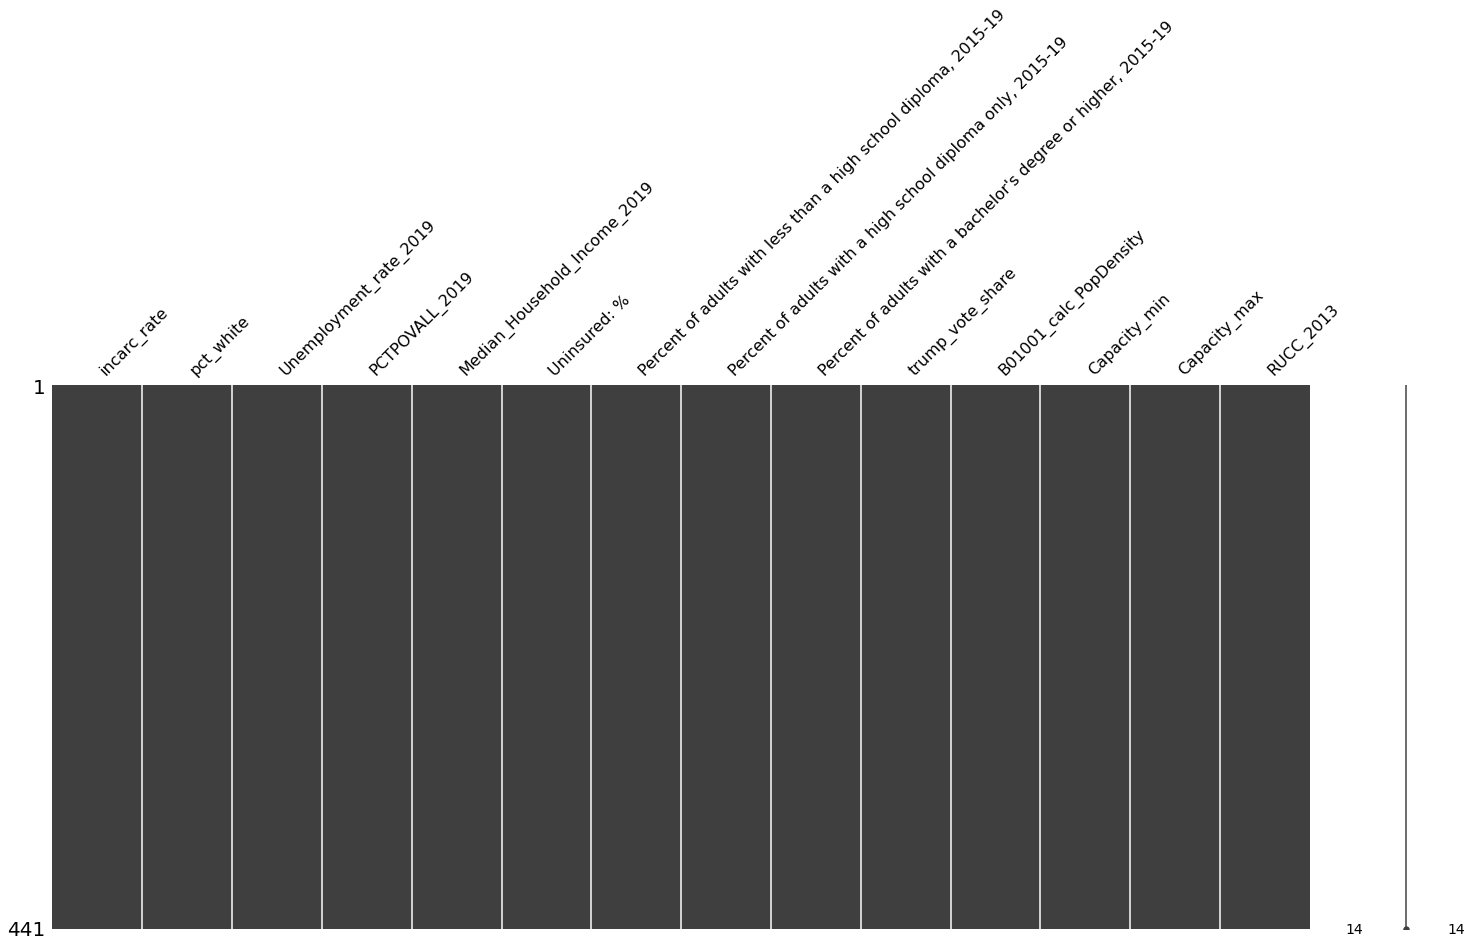

In [70]:
#Explore the training data

#Check for missingness

miss.matrix(train_X) # No missing data

In [71]:
train_X.isna().sum()

incarc_rate                                                        0
pct_white                                                          0
Unemployment_rate_2019                                             0
PCTPOVALL_2019                                                     0
Median_Household_Income_2019                                       0
Uninsured: %                                                       0
Percent of adults with less than a high school diploma, 2015-19    0
Percent of adults with a high school diploma only, 2015-19         0
Percent of adults with a bachelor's degree or higher, 2015-19      0
trump_vote_share                                                   0
B01001_calc_PopDensity                                             0
Capacity_min                                                       0
Capacity_max                                                       0
RUCC_2013                                                          0
dtype: int64

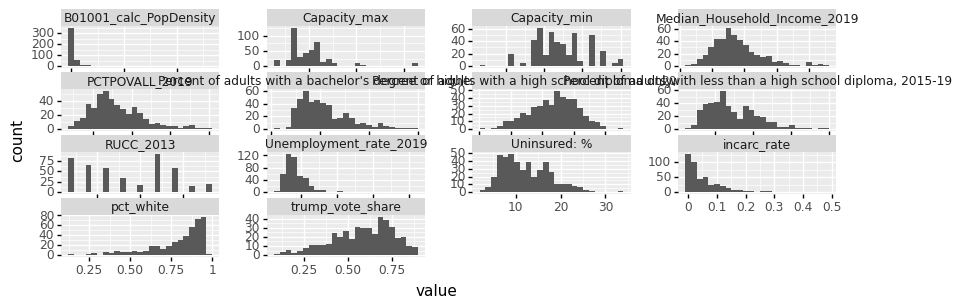

<ggplot: (8784931905419)>

In [72]:
#Explore the training data

# Plot the continuous Variables 
d = train_X.select_dtypes(include="float").melt()
(
    ggplot(d,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,3),
          subplots_adjust={'wspace':0.3, 'hspace': 0.5})
)

As many variables are skewed, they will need to be logged

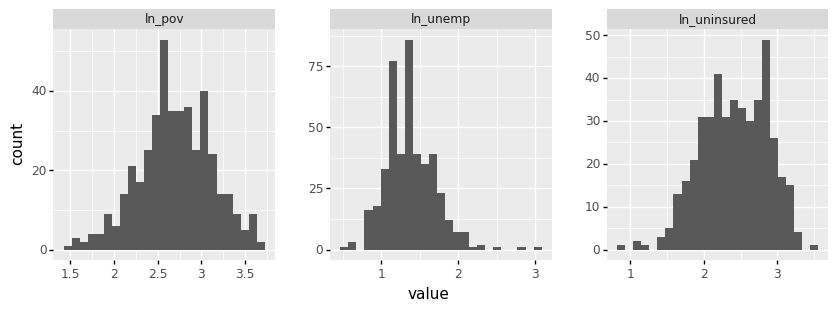

<ggplot: (8784800646756)>

In [73]:
d = train_X.copy()
d['ln_pov'] =  np.log(d['PCTPOVALL_2019'])
d['ln_unemp'] =  np.log(d['Unemployment_rate_2019'])
d['ln_uninsured'] =  np.log(d['Uninsured: %'])

# Plot the continuous Variables 
d = d.filter(['ln_pov', 'ln_unemp', 'ln_uninsured']).melt()
(
    ggplot(d,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,3),
          subplots_adjust={'wspace':0.25})
)

## Pre-Processing Pipeline

In [74]:
#log skewed variables (add 1 as log of 0 is negative infinity)

dat['PCTPOVALL_2019'] =  np.log(dat['PCTPOVALL_2019']+ 1)
dat['Unemployment_rate_2019'] =  np.log(dat['Unemployment_rate_2019'] + 1)
dat['Uninsured: %'] =  np.log(dat['Uninsured: %'] + 1)
dat['incarc_rate'] =  np.log(dat['incarc_rate'] + 1)
dat['B01001_calc_PopDensity'] =  np.log(dat['B01001_calc_PopDensity'] + 1)

#re-split using changed data

y = dat[['cases_diff']]
X = dat.drop(columns=['cases_diff'])

train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=123)


In [75]:
# from sklearn.impute import SimpleImputer 
# imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
# train_X = imputer.fit_transform(train_X)
# test_X = imputer.fit_transform(test_X)

In [76]:
print(train_X.shape[0]/dat.shape[0])
print(test_X.shape[0]/dat.shape[0])

0.7487266553480475
0.25127334465195245


In [77]:
# Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=123)

In [78]:
## Initialize Pipeline

#Note that we still want to scale values, but we want to do this in the pipeline since it utilizes information we'll only learn from the training data (i.e. min/max, mean, std, etc.)

pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

In [79]:
## Select Models & Tuning Parameters

search_space = [
    
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,25,50]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DT()],
     'model__max_depth':[2,3,4]},
    
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
    'model__max_depth':[2,3,4],
    'model__n_estimators':[500,1000,1500]}
    
]



In [80]:
## Run Models


search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)



search.fit(train_X,train_y.cases_diff)

GridSearchCV(cv=KFold(n_splits=5, random_state=123, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [LinearRegression()]},
                         {'model': [KNeighborsClassifier()],
                          'model__n_neighbors': [5, 10, 25, 50]},
                         {'model': [DecisionTreeClassifier()],
                          'model__max_depth': [2, 3, 4]},
                         {'model': [RandomForestClassifier()],
                          'model__max_depth': [2, 3, 4],
                          'model__n_estimators': [500, 1000, 1500]}],
             scoring='neg_mean_squared_error')

In [81]:
search.best_score_

-499.47204810167625

In [82]:
search.best_params_

{'model': LinearRegression()}

In [83]:
# Predict() method will use the best model out of the scan
pred_y = search.predict(test_X)

In [84]:
m.mean_squared_error(test_y,pred_y)

409.6707382908896

In [85]:
m.r2_score(test_y,pred_y)

0.18675985915522442

In [86]:
#train_X

In [87]:
#train_y

In [88]:
#test_X

In [89]:
pred_y.shape

(148,)

In [90]:
test_y.shape

(148, 1)

In [91]:
test_y = test_y['cases_diff'].tolist()

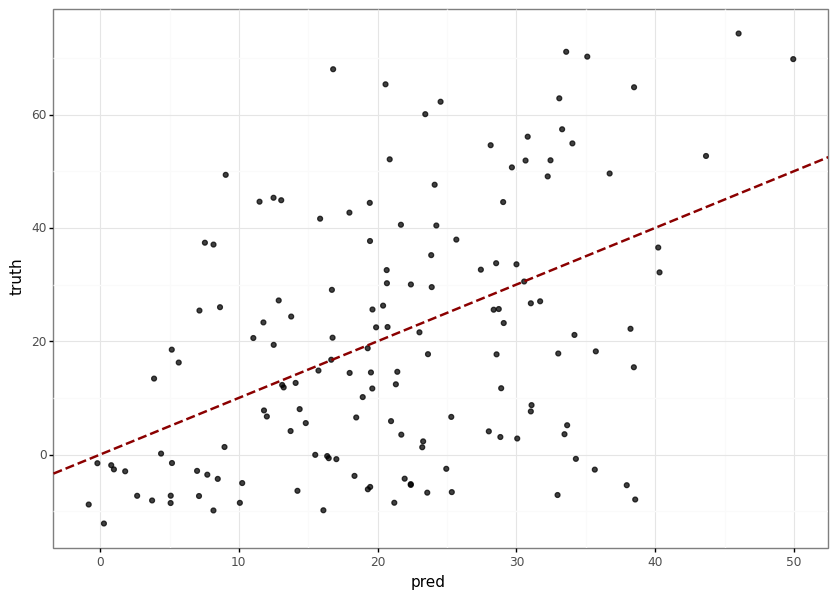

<ggplot: (8784797708165)>

In [92]:
(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=test_y)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    theme(figure_size=(10,7))
)

In [93]:
rf_mod = search.best_estimator_

#Permute the features to determine importance. 
vi = permutation_importance(rf_mod,train_X,train_y,n_repeats=25)

In [94]:
#Permute the features to determine importance. 
vi = permutation_importance(rf_mod,train_X,train_y,n_repeats=25)

In [95]:
#Organize the output as a data frame. 

# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,Percent of adults with a bachelor's degree or ...,0.430720,0.043521,0.343679,0.517761
1,Percent of adults with less than a high school...,0.190759,0.025110,0.140538,0.240979
2,Percent of adults with a high school diploma o...,0.185626,0.017995,0.149636,0.221616
3,Uninsured: %,0.118952,0.014474,0.090004,0.147899
4,pct_white,0.062168,0.012399,0.037370,0.086967
5,Median_Household_Income_2019,0.037881,0.010477,0.016928,0.058834
6,RUCC_2013,0.030064,0.009943,0.010178,0.049950
7,Capacity_max,0.025158,0.007004,0.011149,0.039167
8,Capacity_min,0.023149,0.007853,0.007444,0.038854
9,PCTPOVALL_2019,0.013528,0.006871,-0.000214,0.027269


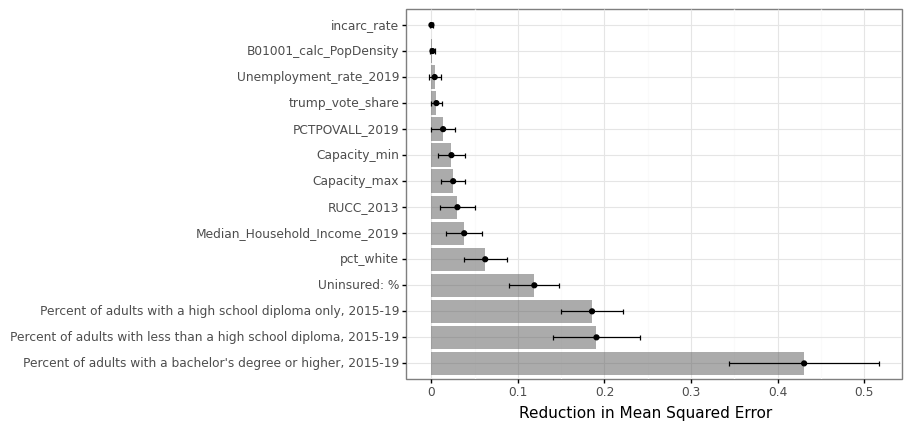

<ggplot: (8784801517803)>

In [96]:
# Plot
(
    ggplot(vi_dat,
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in Mean Squared Error",x="")
)

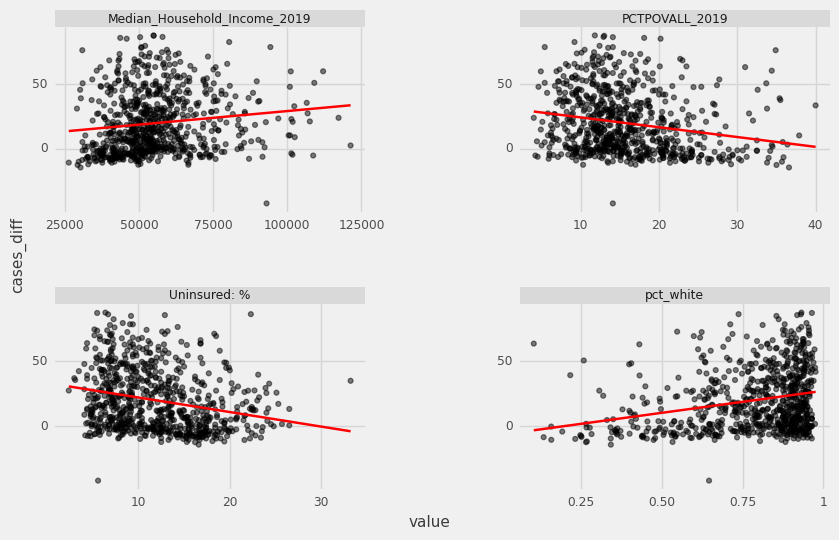

<ggplot: (8784966462766)>

In [99]:
D = final_county[['cases_diff', 'pct_white', 'PCTPOVALL_2019', 'Median_Household_Income_2019', 'Uninsured: %']]

p3 = (
    ggplot(D.melt(id_vars=["cases_diff"]),
           aes(x="value",y="cases_diff"))+
    geom_point(alpha=.5) +
    geom_smooth(method="lm",se=False,color="red") +
    facet_wrap("variable",scales="free") +
    
    theme_538() +
    theme(figure_size = (10,6)) + theme(subplots_adjust={'wspace': 0.5,'hspace': 0.5}) 
)

p3

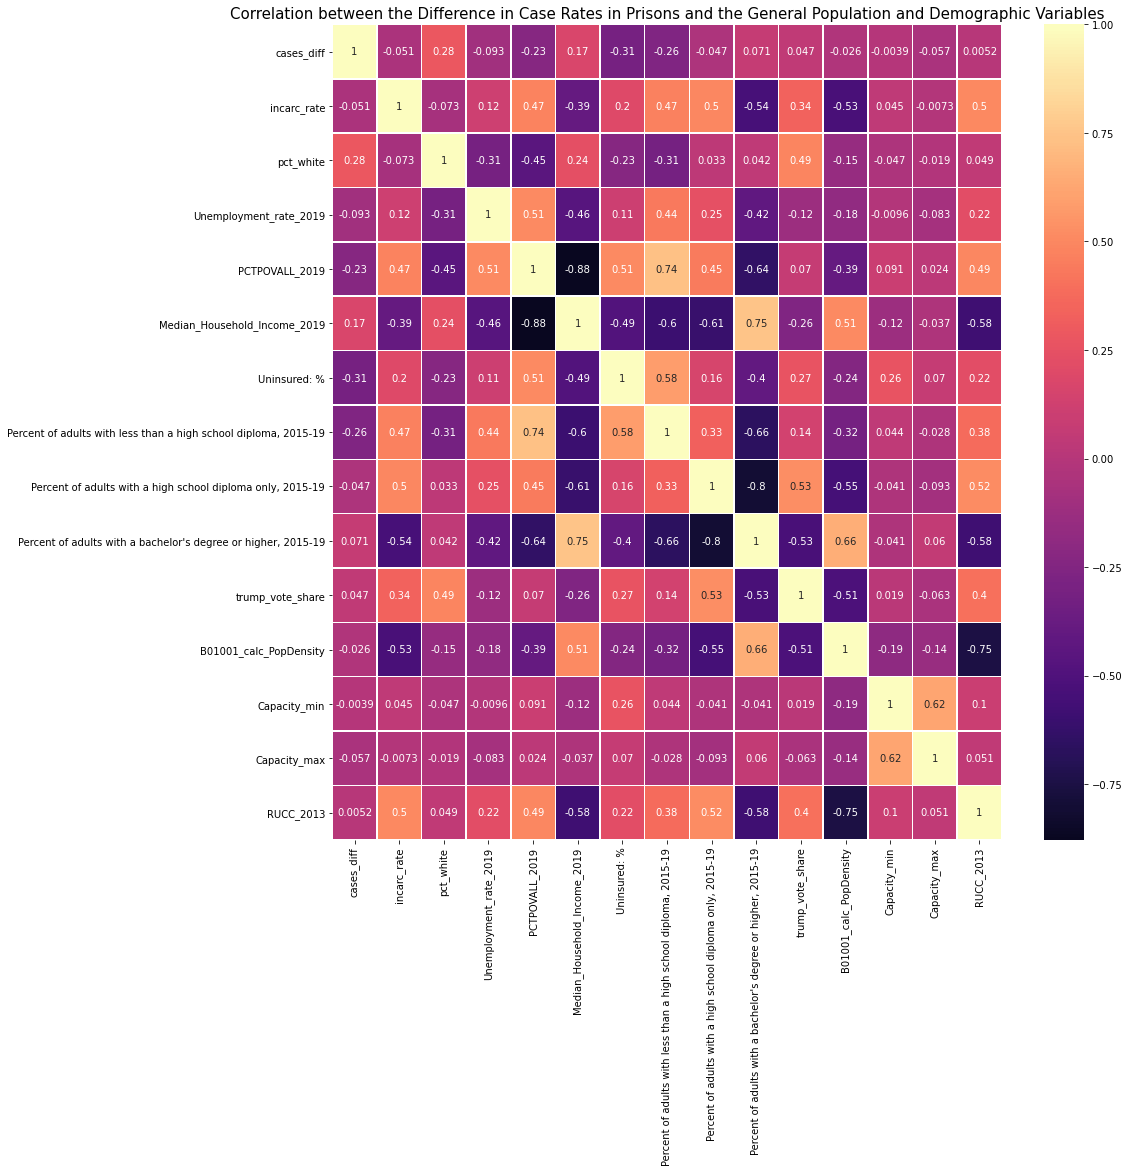

In [100]:
import seaborn as sns

M = dat.corr()

#Plot correlation heatmap
plt.figure(figsize = (15,15))
sns.heatmap(M,center=0,linewidths=.5,cmap="magma", annot = True)
plt.title("Correlation between the Difference in Case Rates in Prisons and the General Population and Demographic Variables", fontsize = 15)
plt.show()